In [ ]:
import random
import numpy as np
from numpy import linalg as LA
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.integrate import odeint
import itertools
import pandas as pd
from tqdm import tqdm
from numpy.polynomial import polynomial as P
import warnings
warnings.filterwarnings('ignore')

### Get determinant value and max-eigenvalues of first patch

In [ ]:
def get_jacobian_first_patch(r,k,beta_1,beta_2,alpha,mu_S,mu_I,JS1,AS1,JI1,AI1):
    N1 = JS1 + AS1 + JI1 + AI1
    delta_1 = (JI1 + AI1)/N1
    eta_1 = (JI1 + AI1)/(N1**2)
    vartheta_1 = (JS1 + AS1)/N1
    J1 = np.array([
        [-1*(p*r*AS1)/(k) - beta_1*delta_1 + beta_1*JS1*eta_1 - (alpha+mu_S), -1*(p*r*AS1)/(k) - beta_1*JS1*vartheta_1, 
         -1*(2*p*r*AS1)/(k) + beta_1*JS1*eta_1, -1*(p*r*AS1)/(k) - beta_1*JS1*vartheta_1],
        [beta_1*delta_1 - beta_1*JS1*eta_1, beta_1*JS1*vartheta_1 - mu_I, -1*beta_1*JS1*eta_1, beta_1*JS1*vartheta_1],
        [alpha + beta_1*AS1*eta_1, beta_1*AS1*vartheta_1, -1*beta_1*delta_1 + beta_1*AS1*eta_1 - mu_S, beta_1*AS1*vartheta_1],
        [-1*beta_1*AS1*eta_1, beta_1*AS1*vartheta_1, beta_1*delta_1 - beta_1*AS1*eta_1, beta_1*AS1*vartheta_1 - mu_I]
    ])
    eigenvalues, eigenvectors = LA.eig(J1)
    return np.max(eigenvalues)

def get_jacobian_second_patch(r,k,beta_1,beta_2,alpha,mu_S,mu_I,AS1,JS2,AS2,JI2,AI2):
    N2 = JS2 + AS2 + JI2 + AI2
    delta_2 = (JI2 + AI2)/N2
    eta_2 = (JI2 + AI2)/(N2**2)
    vartheta_2 = (JS2 + AS2)/N2
    J2 = np.array([
        [-1*(p*r*AS2)/(k) - beta_2*delta_2 + beta_2*JS2*eta_2 - (alpha+mu_S) - ((1-p)*r*AS1)/(k), 
         -1*(p*r*AS2)/(k) - beta_2*JS2*vartheta_2 - ((1-p)*r*AS1)/(k), 
         -1*(2*p*r*AS2)/(k) + beta_2*JS2*eta_2 - ((1-p)*r*AS1)/(k), 
         -1*(p*r*AS2)/(k) - beta_2*JS2*vartheta_2 - ((1-p)*r*AS1)/(k)],
        [beta_2*delta_2 - beta_2*JS2*eta_2, beta_2*JS2*vartheta_2 - mu_I, -1*beta_2*JS2*eta_2, beta_2*JS2*vartheta_2],
        [alpha + beta_2*AS2*eta_2, beta_2*AS2*vartheta_2, -1*beta_2*delta_2 + beta_2*AS2*eta_2 - mu_S, beta_2*AS2*vartheta_2],
        [-1*beta_2*AS2*eta_2, beta_2*AS2*vartheta_2, beta_2*delta_2 - beta_2*AS2*eta_2, beta_2*AS2*vartheta_2 - mu_I]
    ])
    eigenvalues, eigenvectors = LA.eig(J2)
    return np.max(eigenvalues)

In [ ]:
# eigenvalues, eigenvectors = LA.eig(np.diag((1, 2, 3)))
# print(eigenvalues)
# print(np.max(eigenvalues))

### Equilibrium in terms of $R_0^1$

In [ ]:
def get_equilibrium_in_terms_of_R0_1(r,k,beta_2,alpha,mu_S,mu_I,t_max,p,num_sim):

    beta_1s = np.linspace(0.05, 0.8, 501)
    R1s_use = []

    I_1_theoreticals = []

    I_eq_obtaineds_1 = []
    I_eq_obtaineds_2 = []

    S_eq_obtaineds_1 = []
    S_eq_obtaineds_2 = []
    
    max_eig_obtaineds_1 = []
    
    R_p = p/mu_I
    R_alpha = alpha/mu_I
    R_s = mu_S/mu_I

    root_1 = 1 - R_s + (R_alpha/2)*(-1 - np.sqrt(1+ 4*r*R_p/R_alpha)) 
    root_2 = 1 - R_s + (R_alpha/2)*(-1 + np.sqrt(1+ 4*r*R_p/R_alpha)) 

    print(f'root 1: {root_1}, root 2: {root_2}')

    
    for beta_1 in tqdm(beta_1s):
        for _ in range(num_sim):
            try:
                # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
                x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])

                new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
                new_pycno.solve_odes_system_odeint()

                R_0 = beta_1/mu_I
                I_1_theoretical = ((k*(R_0-1))/(r*R_p*R_alpha*R_0))*(r*R_p*R_alpha - (R_0 + R_s + R_alpha -1)*(R_0 + R_s -1))

                I_eq_obtained_1 = new_pycno.Ji1[-1] + new_pycno.Ai1[-1]
                I_eq_obtained_2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]

                S_eq_obtained_1 = new_pycno.Js1[-1] + new_pycno.As1[-1]
                S_eq_obtained_2 = new_pycno.Js2[-1] + new_pycno.As2[-1]

                R1s_use.append(beta_1/mu_I)
                
                max_eig1 = get_jacobian_first_patch(r, k, beta_1, beta_2, alpha, mu_S, mu_I,
                                                                    JS1=new_pycno.Js1[-1],AS1=new_pycno.Js1[-1],
                                                                    JI1=new_pycno.Ji1[-1],AI1=new_pycno.Ai1[-1])
                
                if max_eig1 < 0:
                
                    I_eq_obtaineds_1.append(I_eq_obtained_1)
                    I_eq_obtaineds_2.append(I_eq_obtained_2)

                    S_eq_obtaineds_1.append(S_eq_obtained_1)
                    S_eq_obtaineds_2.append(S_eq_obtained_2)

                    I_1_theoreticals.append(I_1_theoretical)

                    max_eig_obtaineds_1.append(max_eig1)
                    
            except Exception as e:
                print(e)
                pass
    return R1s_use, I_1_theoreticals, I_eq_obtaineds_1, I_eq_obtaineds_2, S_eq_obtaineds_1, S_eq_obtaineds_2, max_eig_obtaineds_1

In [ ]:
r = 1
k = 1
# beta_1 = 0.3
beta_2 = 0.3
alpha = 0.1
mu_S = 0.08
mu_I = 0.1
t_max = 2000
p = 0.5
num_sim = 10

R1s_use, I_1_theoreticals, I_eq_obtaineds_1, \
I_eq_obtaineds_2, S_eq_obtaineds_1, S_eq_obtaineds_2, max_eig_obtaineds_1 = get_equilibrium_in_terms_of_R0_1(r,k,beta_2,
                                                                                        alpha,mu_S,
                                                                                        mu_I,t_max,p,num_sim)

fig = plt.figure()
ax1 = fig.add_subplot(111)

nn = 1300
ax1.scatter(R1s_use[0:nn], I_eq_obtaineds_1[0:nn], s=10, marker='o', color='#E58C70', label=r'$I_1^*$ attained by the system')
# ax1.scatter(R1s_use[0:nn], I_eq_obtaineds_2[0:nn], s=10, marker='o', color='#C74B24', label=r'$I_2^*$ attained by the system')

ax1.scatter(R1s_use[0:nn], S_eq_obtaineds_1[0:nn], s=10, marker='o', color='#689CDE', label=r'$S_1^*$ attained by the system')
# ax1.scatter(R1s_use[0:nn], S_eq_obtaineds_2[0:nn], s=10, marker='o', color='#246AC4', label=r'$S_2^*$ attained by the system')

ax1.scatter(R1s_use[0:nn], max_eig_obtaineds_1[0:nn], s=10, marker='o', color='green', label=r'Max Eigenvalue of $\mathcal{J}_1$')

ax1.figure.set_size_inches(10, 5)

plt.legend(loc='upper right')
plt.xlabel(r"$R_0^1$")
plt.title(r"Infected/Susceptible equilibrium in terms of $R_0^1$ (with $R_0^2>1$)")
plt.show()

In [ ]:
# print(f"""
# R01s = {{ {','.join([str(round(x,4)) for x in R1s_use[0:nn]])} }}; \n
# infP1 = {{ {','.join([str(round(x,4)) for x in I_eq_obtaineds_1[0:nn]])} }}; \n
# maxeigs1 = {{ {','.join([str(round(np.real(x),4)) for x in  max_eig_obtaineds_1[0:nn]])} }};
# """)

### Equilibrium in terms of $R_0^2$

In [ ]:
def get_equilibrium_in_terms_of_R0_2(r,k,beta_1,alpha,mu_S,mu_I,t_max,p,num_sim):

    beta_2s = np.linspace(0.05, 0.8, 201)
    R2s_use = []

    I_eq_obtaineds_1 = []
    I_eq_obtaineds_2 = []

    S_eq_obtaineds_1 = []
    S_eq_obtaineds_2 = []
    
    max_eig_obtaineds_2 = []

    for beta_2 in tqdm(beta_2s):
        for _ in range(num_sim):
            try:
                # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
                x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])

                new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
                new_pycno.solve_odes_system_odeint()

                I_eq_obtained_1 = new_pycno.Ji1[-1] + new_pycno.Ai1[-1]
                I_eq_obtained_2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]

                S_eq_obtained_1 = new_pycno.Js1[-1] + new_pycno.As1[-1]
                S_eq_obtained_2 = new_pycno.Js2[-1] + new_pycno.As2[-1]
                
                
                max_eig2 = get_jacobian_second_patch(r, k, beta_1, beta_2, alpha, mu_S, mu_I,
                                                     AS1=new_pycno.As1[-1],
                                                     JS2=new_pycno.Js2[-1],
                                                     AS2=new_pycno.Js2[-1],
                                                     JI2=new_pycno.Ji2[-1],
                                                     AI2=new_pycno.Ai2[-1])

                R2s_use.append(beta_2/mu_I)

                I_eq_obtaineds_1.append(I_eq_obtained_1)
                I_eq_obtaineds_2.append(I_eq_obtained_2)

                S_eq_obtaineds_1.append(S_eq_obtained_1)
                S_eq_obtaineds_2.append(S_eq_obtained_2)
                
                max_eig_obtaineds_2.append(max_eig2) 

            except Exception as e:
                print(e)
                pass
    return R2s_use, I_eq_obtaineds_1, I_eq_obtaineds_2, S_eq_obtaineds_1, S_eq_obtaineds_2, max_eig_obtaineds_2

In [ ]:
beta_1 = 0.25
print(mu_I)
print(beta_1/mu_I)

R2s_use, I_eq_obtaineds_1, I_eq_obtaineds_2, \
S_eq_obtaineds_1, S_eq_obtaineds_2, max_eig_obtaineds_2 = get_equilibrium_in_terms_of_R0_2(r,k,beta_1,
                                                                      alpha,mu_S,
                                                                      mu_I,t_max,
                                                                      p,num_sim)
nn = 1000

fig = plt.figure()
ax1 = fig.add_subplot(111)

R2s_use_ = []
I_eq_obtaineds_2_ = []
max_eig_obtaineds_2_ = []

for i in tqdm(range(nn)):
    if max_eig_obtaineds_2[i]<0:
        R2s_use_.append(R2s_use[i])
        I_eq_obtaineds_2_.append(I_eq_obtaineds_2[i])
        max_eig_obtaineds_2_.append(max_eig_obtaineds_2[i])

# ax1.scatter(R2s_use[0:nn], I_eq_obtaineds_1[0:nn], s=15, marker='o', color='#E58C70', label=r'$I_1^*$ attained by the system')
ax1.scatter(R2s_use_, I_eq_obtaineds_2_, s=5, marker='o', color='#C74B24', label=r'$I_2^*$ attained by the system')
# ax1.scatter(R2s_use[0:nn], S_eq_obtaineds_1[0:nn], s=15, marker='o', color='#689CDE', label=r'$S_1^*$ attained by the system')
#ax1.scatter(R2s_use[0:nn], S_eq_obtaineds_2[0:nn], s=5, marker='o', color='#246AC4', label=r'$S_2^*$ attained by the system')
ax1.scatter(R2s_use_, max_eig_obtaineds_2_, s=10, marker='o', color='green', label=r'Max Eigenvalue of $\mathcal{J}_2$')

ax1.figure.set_size_inches(10, 5)

plt.legend(loc='upper right')
plt.xlabel(r"$R_0^2$")
plt.title(r"Infected/Susceptible equilibrium in terms of $R_0^2$ (with $R_0^1>1$)")
plt.show()

In [ ]:
# print(f"""
# R02s3 = {{ {','.join([str(round(x,4)) for x in R2s_use_])} }}; \n
# infP23 = {{ {','.join([str(round(x,4)) for x in I_eq_obtaineds_2_])} }}; \n
# maxeigs3 = {{ {','.join([str(round(np.real(x),4)) for x in  max_eig_obtaineds_2_])} }};
# """)

## Equilibriums in terms of both $R_0^1$ and $R_0^2$

In [ ]:
beta_1s = np.linspace(0.05, 0.8, 51)
beta_2s = np.linspace(0.05, 0.8, 51)

r = 1
k = 1
alpha = 0.6
mu_S = 0.1
mu_I = 0.1
p = 0.5

t_max = 2000
num_sim = 10

combs = list(itertools.product(beta_1s, beta_2s))

dat_ = pd.DataFrame({})

for comb in tqdm(combs):

    beta_1 = round(comb[0],3)
    beta_2 = round(comb[1],3)
    
    I_eq_obtaineds_1 = []
    I_eq_obtaineds_2 = []
    S_eq_obtaineds_1 = []
    S_eq_obtaineds_2 = []
    
    for _ in range(num_sim):

        try:
            # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
            x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])
            
            new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
            new_pycno.solve_odes_system_odeint()
            
            I_eq_obtained_1 = new_pycno.Ji1[-1] + new_pycno.Ai1[-1]
            I_eq_obtained_2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]
            
            S_eq_obtained_1 = new_pycno.Js1[-1] + new_pycno.As1[-1]
            S_eq_obtained_2 = new_pycno.Js2[-1] + new_pycno.As2[-1]

            I_eq_obtaineds_1.append(I_eq_obtained_1)
            I_eq_obtaineds_2.append(I_eq_obtained_2)
            
            S_eq_obtaineds_1.append(S_eq_obtained_1)
            S_eq_obtaineds_2.append(S_eq_obtained_2)
            
        except Exception as e:
            print('Error with', beta_1, beta_2, ":", e)
            pass
        
    Ieq_obt_1 = np.mean(I_eq_obtaineds_1)
    Ieq_obt_2 = np.mean(I_eq_obtaineds_2)
    Seq_obt_1 = np.mean(S_eq_obtaineds_1)
    Seq_obt_2 = np.mean(S_eq_obtaineds_2)

    dat_ = pd.concat([dat_, pd.DataFrame({
        'R_0_1' : [round(beta_1/mu_I,3)],
        'R_0_2' : [round(beta_2/mu_I,3)],
        'Ieq_obt_1' : [Ieq_obt_1],
        'Ieq_obt_2' : [Ieq_obt_2],
        'Seq_obt_1' : [Seq_obt_1],
        'Seq_obt_2' : [Seq_obt_2],
    })], ignore_index=True)

In [ ]:
dat_0 = dat_.copy()
dat_0.to_csv('./dat00.csv', index=False)

In [4]:
# dat_.to_csv('./dat.csv', index=False)
dat_ = pd.read_csv('./dat0.csv')

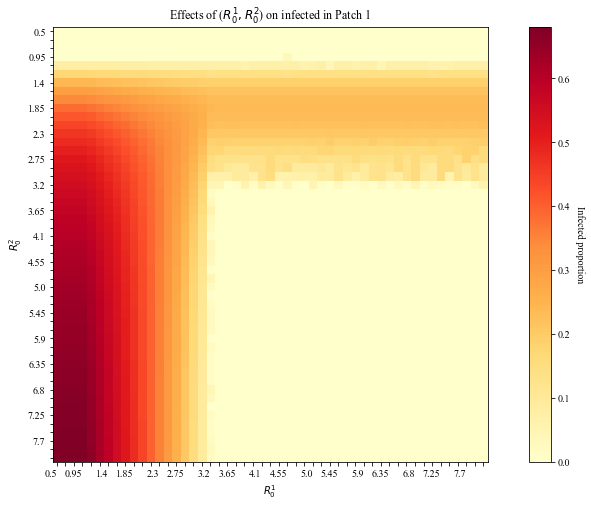

In [5]:
plot1_data = dat_.pivot(index='R_0_1', columns='R_0_2', values='Ieq_obt_2')
# Labels
xlabs = list(plot1_data.index)
ylabs = plot1_data.columns.tolist()
data = np.transpose(np.abs(plot1_data.values))

# Heat map
fig, ax = plt.subplots()
im = ax.imshow(data, cmap = "YlOrRd")

# Add the labels
# We want to show all ticks...
ax.set_xticks(np.arange(len(xlabs)))
ax.set_yticks(np.arange(len(ylabs)))
# ... and label them with the respective list entries
ax.set_xticklabels(xlabs)
ax.set_yticklabels(ylabs)

ax.figure.set_size_inches(15, 8)

# Rotate the labels of the X-axis
plt.setp(ax.get_xticklabels(), rotation = 0,
         ha = "right", rotation_mode = "anchor")

n = 3
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

for index, label in enumerate(ax.yaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

# Add the color bar
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Infected proportion", rotation = -90, va = "bottom")
plt.title(f"Effects of ($R_0^1, R_0^2$) on infected in Patch 1")
plt.xlabel("$R_0^1$")
plt.ylabel("$R_0^2$")
plt.show()

In [6]:
# xlabs = list(plot1_data.index)
# ylabs = plot1_data.columns.tolist()
# print(','.join([f"{{{i+1},Rotate[{x}, \[Pi]/2]}}" for i, x in enumerate(xlabs) if i%2 == 0]))
for dat in data:
    print(f"{{ {','.join([f'{d:.10f}' for d in dat])} }},")

{ 0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000 },
{ 0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.000

## Third root of $I_1$ is not greater than 1.
This is a special case, completely different than the previous case. It occurs for example, when the parameter $\alpha$ is very small.

In [ ]:
beta_2 = 0.3
alpha = 0.02
t_max = 5000

R1s_use, I_1_theoreticals, I_eq_obtaineds_1, \
I_eq_obtaineds_2, S_eq_obtaineds_1, S_eq_obtaineds_2 = get_equilibrium_in_terms_of_R0_1(r,k,beta_2,
                                                                                        alpha,mu_S,
                                                                                        mu_I,t_max,p,num_sim)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(R1s_use, I_eq_obtaineds_1, s=10, marker='o', color='#E58C70', label=r'$I_1^*$ attained by the system')
ax1.scatter(R1s_use, I_eq_obtaineds_2, s=10, marker='o', color='#C74B24', label=r'$I_2^*$ attained by the system')

ax1.scatter(R1s_use, S_eq_obtaineds_1, s=10, marker='o', color='#689CDE', label=r'$S_1^*$ attained by the system')
ax1.scatter(R1s_use, S_eq_obtaineds_2, s=10, marker='o', color='#246AC4', label=r'$S_2^*$ attained by the system')

ax1.figure.set_size_inches(10, 5)

plt.legend(loc='upper right')
plt.xlabel(r"$R_0^1$")
plt.title(r"Infected/Susceptible equilibrium in terms of $R_0^1$ (with $R_0^2<1$)")
plt.show()

### Relation between $I_2^*$ and $A_{S,1}^*$

In [ ]:
polyroots = pd.read_csv('upperBranch.csv')
polyroots.columns = ['AS1', 'I2']

r = 1
k = 1
alpha = 0.6
mu_S = 0.1
mu_I = 0.1
p = 0.5
t_max = 2000
num_sim = 2

beta_1s = np.linspace(0.05, 0.8, 51)
beta_2 = 0.11

R_p = p/mu_I
R_alpha = alpha/mu_I
R_s = mu_S/mu_I

plt.figure(figsize=(10,8))

for idx, beta_2 in enumerate([0.15,0.2,0.25,0.3,0.35,0.4]):

    # beta_2 = 0.6

    R1s_use = []
    I_1_theoreticals = []
    I_2_theoreticals = []
    I_eq_obtaineds_1 = []
    I_eq_obtaineds_2 = []
    AS_obtaineds_1 = []
    poly_vals = []

    R_0_2 = beta_2/mu_I
    lambda_2 = (R_alpha)/(R_0_2 + R_s - 1)

    for beta_1 in tqdm(beta_1s):

        for _ in range(num_sim):

            try:
                # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
                x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])

                new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
                new_pycno.solve_odes_system_odeint()

                R_0_1 = beta_1/mu_I
                I_1_theoretical = ((k*(R_0_1-1))/(r*R_p*R_alpha*R_0_1))*(r*R_p*R_alpha - (R_0_1 + R_s + R_alpha -1)*(R_0_1 + R_s -1))

                I_eq_obtained_1 = new_pycno.Ji1[-1] + new_pycno.Ai1[-1]
                I_eq_obtained_2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]
                AS_obtained_1 = new_pycno.As1[-1]

                coef_1 = (p*r*lambda_2*R_0_2)/(k*(lambda_2 + 1)*(R_0_2 -1)**2)
                coef_2 = (1/((lambda_2+1)*(R_0_2 -1)))*(-1*p*r*lambda_2 + (beta_2*(R_0_2 - 1))/(R_0_2)  + alpha + mu_S) + ((1-p)*r*R_0_2*AS_obtained_1)/(k*(R_0_2-1))
                coef_3 = -1*(1-p)*r*AS_obtained_1
                poly_val = coef_1*(I_eq_obtained_2)**2 + coef_2*(I_eq_obtained_2) + coef_3

                try:
                    roots = P.polyroots((coef_3,coef_2,coef_1))
                    I_2_theoretical = [rt for rt in roots if rt>0][0]
                except Exception:
                    I_2_theoretical = 0

                # N_2 = new_pycno.Js2[-1] + new_pycno.As2[-1] + new_pycno.Ji2[-1] + new_pycno.Ai2[-1]
                # poly_val = (1-p)*r*(1-(N_2/k))*AS_obtained_1 + p*r*(1-(N_2/k))*new_pycno.As2[-1]
                # poly_val = poly_val - beta_2*new_pycno.Js2[-1]*(I_eq_obtained_2/N_2) - (alpha+mu_S)*new_pycno.Js2[-1]

                AS_obtained_1r = round(AS_obtained_1,5)
                if AS_obtained_1r not in AS_obtaineds_1:
                    R1s_use.append(beta_1/mu_I)
                    I_1_theoreticals.append(I_1_theoretical)
                    I_2_theoreticals.append(I_2_theoretical)
                    I_eq_obtaineds_1.append(I_eq_obtained_1)
                    I_eq_obtaineds_2.append(I_eq_obtained_2)
                    AS_obtaineds_1.append(AS_obtained_1)
                    poly_vals.append(poly_val)

            except Exception as e:
                print(e)
                pass
            
    # print(f"""
    # AS1{idx} =  {{ {','.join([str(abs(round(x,5))).replace('nan', 'NaN') for x in AS_obtaineds_1])} }};
    # I2{idx} =  {{ {','.join([str(abs(round(x,5))).replace('nan', 'NaN') for x in I_eq_obtaineds_2])} }};
    # """)

    plt.plot(AS_obtaineds_1, I_eq_obtaineds_2, color=px.colors.qualitative.G10[idx], label="$I_2^*$ obtained. R_0_2 = "+str(round(beta_2/mu_I,2)))

plt.title("$I_2^*$ depending on $A_{S,1}^*$")
plt.legend(loc="lower right")
plt.show()

### Effect of $\alpha$

In [ ]:
r = 1
k = 1
mu_S = 0.1
mu_I = 0.1
p = 0.5
t_max = 2000
num_sim = 2

beta_1 = 0.25
beta_2 = 0.5

R_p = p/mu_I
R_alpha = alpha/mu_I
R_s = mu_S/mu_I

R_0_2 = beta_2/mu_I
lambda_2 = (R_alpha)/(R_0_2 + R_s - 1)

alphas_use = []
I_1_theoreticals = []
I_2_theoreticals = []
I_eq_obtaineds_1 = []
I_eq_obtaineds_2 = []
AS_obtaineds_1 = []

for alpha in tqdm(np.linspace(0.001, 1, 101)):
    
    for _ in range(num_sim):

        try:
            # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
            x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])

            new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
            new_pycno.solve_odes_system_odeint()

            I_eq_obtained_1 = new_pycno.Ji1[-1] + new_pycno.Ai1[-1]
            I_eq_obtained_2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]
            AS_obtained_1 = new_pycno.As1[-1]
 
            I_eq_obtaineds_1.append(I_eq_obtained_1)
            I_eq_obtaineds_2.append(I_eq_obtained_2)
            AS_obtaineds_1.append(AS_obtained_1)
            alphas_use.append(alpha)

        except Exception as e:
            print(e)
            pass

plt.figure(figsize=(10,8))
plt.plot(alphas_use, I_eq_obtaineds_1, color=px.colors.qualitative.G10[0], label="$I_1^*$")
plt.plot(alphas_use, I_eq_obtaineds_2, color=px.colors.qualitative.G10[1], label="$I_2^*$")
plt.title("$I^*$ depending on $\\alpha$")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# print(f"""
# alphas =  {{ {','.join([str(abs(round(x,5))).replace('nan', 'NaN') for x in alphas_use])} }};
# I1s =  {{ {','.join([str(abs(round(x,5))).replace('nan', 'NaN') for x in I_eq_obtaineds_1])} }};
# I2s =  {{ {','.join([str(abs(round(x,5))).replace('nan', 'NaN') for x in I_eq_obtaineds_2])} }};
# """)


In [ ]:
beta_1 = 0.25
beta_2s = np.linspace(0.05, 0.8, 51)
alphas = np.linspace(0.001, 1, 51)

r = 1
k = 1
alpha = 0.6
mu_S = 0.1
mu_I = 0.1
p = 0.5

t_max = 2000
num_sim = 10

combs = list(itertools.product(alphas, beta_2s))

dat_ = pd.DataFrame({})

for comb in tqdm(combs):

    alpha = round(comb[0],3)
    beta_2 = round(comb[1],3)
    
    I_eq_obtaineds_1 = []
    I_eq_obtaineds_2 = []
    S_eq_obtaineds_1 = []
    S_eq_obtaineds_2 = []
    
    for _ in range(num_sim):

        try:
            # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
            x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])
            
            new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
            new_pycno.solve_odes_system_odeint()
            
            I_eq_obtained_1 = new_pycno.Ji1[-1] + new_pycno.Ai1[-1]
            I_eq_obtained_2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]
            
            S_eq_obtained_1 = new_pycno.Js1[-1] + new_pycno.As1[-1]
            S_eq_obtained_2 = new_pycno.Js2[-1] + new_pycno.As2[-1]

            I_eq_obtaineds_1.append(I_eq_obtained_1)
            I_eq_obtaineds_2.append(I_eq_obtained_2)
            
            S_eq_obtaineds_1.append(S_eq_obtained_1)
            S_eq_obtaineds_2.append(S_eq_obtained_2)
            
        except Exception as e:
            print('Error with', beta_1, beta_2, ":", e)
            pass
        
    Ieq_obt_1 = np.mean(I_eq_obtaineds_1)
    Ieq_obt_2 = np.mean(I_eq_obtaineds_2)
    Seq_obt_1 = np.mean(S_eq_obtaineds_1)
    Seq_obt_2 = np.mean(S_eq_obtaineds_2)

    dat_ = pd.concat([dat_, pd.DataFrame({
        'alpha' : [round(alpha,3)],
        'R_0_2' : [round(beta_2/mu_I,3)],
        'Ieq_obt_1' : [Ieq_obt_1],
        'Ieq_obt_2' : [Ieq_obt_2],
        'Seq_obt_1' : [Seq_obt_1],
        'Seq_obt_2' : [Seq_obt_2],
    })], ignore_index=True)

In [ ]:
dat0_alphas = dat_.copy()
dat0_alphas.to_csv('data_alphas.csv', index=False)

In [ ]:
dat_ = pd.read_csv('data_alphas.csv')

In [ ]:
plot1_data = dat_.pivot(index='alpha', columns='R_0_2', values='Ieq_obt_2')
# Labels
xlabs = list(plot1_data.index)
ylabs = plot1_data.columns.tolist()
data = np.transpose(np.abs(plot1_data.values))

# Heat map
fig, ax = plt.subplots()
im = ax.imshow(data, cmap = "YlOrRd")

# Add the labels
# We want to show all ticks...
ax.set_xticks(np.arange(len(xlabs)))
ax.set_yticks(np.arange(len(ylabs)))
# ... and label them with the respective list entries
ax.set_xticklabels(xlabs)
ax.set_yticklabels(ylabs)

ax.figure.set_size_inches(15, 8)

# Rotate the labels of the X-axis
plt.setp(ax.get_xticklabels(), rotation = 0,
         ha = "right", rotation_mode = "anchor")

n = 3
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

for index, label in enumerate(ax.yaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

# Add the color bar
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Susceptible proportion", rotation = -90, va = "bottom")
plt.title(f"Effects of ($R_0^1, R_0^2$) on susceptible in Patch 2")
plt.xlabel("$\\alpha$")
plt.ylabel("$R_0^2$")
plt.show()

In [ ]:
# for dat in data:
#     print(f"{{ {','.join([f'{d:.4f}' for d in dat])} }},")
# xlabs = list(plot1_data.index)
# print(','.join([f"{{{i+1},Rotate[{x}, \[Pi]/2]}}" for i, x in enumerate(xlabs) if i%2 == 0]))

### Effect of $p$

In [ ]:
beta_1 = 0.25
beta_2s = np.linspace(0.05, 0.8, 51)
pps_ = np.linspace(0.001, 1, 51)

r = 1
k = 1
alpha = 0.6
mu_S = 0.1
mu_I = 0.1

t_max = 2000
num_sim = 10

combs = list(itertools.product(pps_, beta_2s))

datp_ = pd.DataFrame({})

for comb in tqdm(combs):

    p = round(comb[0],3)
    beta_2 = round(comb[1],3)
    
    I_eq_obtaineds_1 = []
    I_eq_obtaineds_2 = []
    S_eq_obtaineds_1 = []
    S_eq_obtaineds_2 = []
    
    for _ in range(num_sim):

        try:
            # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
            x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])
            
            new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
            new_pycno.solve_odes_system_odeint()
            
            I_eq_obtained_1 = new_pycno.Ji1[-1] + new_pycno.Ai1[-1]
            I_eq_obtained_2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]
            
            S_eq_obtained_1 = new_pycno.Js1[-1] + new_pycno.As1[-1]
            S_eq_obtained_2 = new_pycno.Js2[-1] + new_pycno.As2[-1]

            I_eq_obtaineds_1.append(I_eq_obtained_1)
            I_eq_obtaineds_2.append(I_eq_obtained_2)
            
            S_eq_obtaineds_1.append(S_eq_obtained_1)
            S_eq_obtaineds_2.append(S_eq_obtained_2)
            
        except Exception as e:
            print('Error with', beta_1, beta_2, ":", e)
            pass
        
    Ieq_obt_1 = np.mean(I_eq_obtaineds_1)
    Ieq_obt_2 = np.mean(I_eq_obtaineds_2)
    Seq_obt_1 = np.mean(S_eq_obtaineds_1)
    Seq_obt_2 = np.mean(S_eq_obtaineds_2)
    datp_ = pd.concat([datp_, pd.DataFrame({
        'p' : [round(p,3)],
        'R_0_2' : [round(beta_2/mu_I,3)],
        'Ieq_obt_1' : [Ieq_obt_1],
        'Ieq_obt_2' : [Ieq_obt_2],
        'Seq_obt_1' : [Seq_obt_1],
        'Seq_obt_2' : [Seq_obt_2],
    })], ignore_index=True)

In [ ]:
# dat0_pps = datp_.copy()
# dat0_pps.to_csv('data_pps.csv', index=False)

In [ ]:
datp_ = pd.read_csv('data_pps.csv')

In [ ]:
plot1_data = datp_.pivot(index='p', columns='R_0_2', values='Ieq_obt_2')
# Labels
xlabs = list(plot1_data.index)
ylabs = plot1_data.columns.tolist()
data = np.transpose(np.abs(plot1_data.values))

# Heat map
fig, ax = plt.subplots()
im = ax.imshow(data, cmap = "YlOrRd")

# Add the labels
# We want to show all ticks...
ax.set_xticks(np.arange(len(xlabs)))
ax.set_yticks(np.arange(len(ylabs)))
# ... and label them with the respective list entries
ax.set_xticklabels(xlabs)
ax.set_yticklabels(ylabs)

ax.figure.set_size_inches(15, 8)

# Rotate the labels of the X-axis
plt.setp(ax.get_xticklabels(), rotation = 0,
         ha = "right", rotation_mode = "anchor")

n = 3
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

for index, label in enumerate(ax.yaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

# Add the color bar
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Susceptible proportion", rotation = -90, va = "bottom")
plt.title(f"Effects of ($R_0^1, R_0^2$) on susceptible in Patch 2")
plt.xlabel("$\\alpha$")
plt.ylabel("$R_0^2$")
plt.show()

In [ ]:
# for dat in data:
#     print(f"{{ {','.join([f'{d:.4f}' for d in dat])} }},")

In [ ]:
beta_1 = 0.3
beta_2 = 0.4
alphas_ = np.linspace(0.01, 1, 51)
pps_ = np.linspace(0.01, 1, 51)

r = 1
k = 1
mu_S = 0.1
mu_I = 0.1

t_max = 4000
num_sim = 1

combs = list(itertools.product(alphas_, pps_))

datalphap_ = pd.DataFrame({})

for comb in tqdm(combs):

    alpha = round(comb[0],3)
    p = round(comb[1],3)
    ratios_1 = []
    ratios_2 = []
    I_eqs1 = []
    I_eqs2 = []

    for _ in range(num_sim):

        try:
            # JS1, JI1, AS1, AI1, JS2, JI2, AS2, AI2
            x00 = list(np.random.dirichlet(np.ones(8),size=1)[0])
            
            new_pycno = PycnoSIX(mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max)
            new_pycno.solve_odes_system_odeint()
            
            I1 = new_pycno.Ji1[-1] + new_pycno.Ai1[-1]
            I2 = new_pycno.Ji2[-1] + new_pycno.Ai2[-1]
            
            ratio1 = new_pycno.Js1[-1]/new_pycno.As1[-1]
            ratio2 = new_pycno.Js2[-1]/new_pycno.As2[-1]
            
            if max(abs(new_pycno.Js2[-1]), abs(new_pycno.As2[-1])) < 1e-6:
                ratio2 = 0

            ratios_1.append(ratio1)
            ratios_2.append(ratio2)
            
            I_eqs1.append(I1)
            I_eqs2.append(I2)
            
        except Exception as e:
            print('Error with', beta_1, beta_2, ":", e)
            pass

    ratio1_ = np.mean(ratios_1)
    ratio2_ = np.mean(ratios_2)
    I_eq1_ = np.mean(I_eqs1)
    I_eq2_ = np.mean(I_eqs2)

    datalphap_ = pd.concat([datalphap_, pd.DataFrame({
        'p' : [round(p,3)],
        'alpha' : [round(alpha,3)],
        'ratio1': [ratio1_],
        'ratio2': [ratio2_],
        'Ieq1': [I_eq1_],
        'Ieq2': [I_eq2_]
    })], ignore_index=True)

In [ ]:
plot1_data = datalphap_.pivot(index='alpha', columns='p', values='ratio2')
# Labels
xlabs = list(plot1_data.index)
ylabs = plot1_data.columns.tolist()
data = np.transpose(np.abs(plot1_data.values))

# Heat map
fig, ax = plt.subplots()
im = ax.imshow(data, cmap = "YlOrRd")

# Add the labels
# We want to show all ticks...
ax.set_xticks(np.arange(len(xlabs)))
ax.set_yticks(np.arange(len(ylabs)))
# ... and label them with the respective list entries
ax.set_xticklabels(xlabs)
ax.set_yticklabels(ylabs)

ax.figure.set_size_inches(15, 8)

# Rotate the labels of the X-axis
plt.setp(ax.get_xticklabels(), rotation = 0,
         ha = "right", rotation_mode = "anchor")

n = 3
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

for index, label in enumerate(ax.yaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)

# Add the color bar
cbar = ax.figure.colorbar(im, ax = ax)
cbar.ax.set_ylabel("Ratio", rotation = -90, va = "bottom")
plt.title("Effects of ($p, \\alpha$) on ratio $J_{S,2}/A_{S,2}$")
plt.xlabel("$\\alpha$")
plt.ylabel("$p$")
plt.show()

In [ ]:
# for dat in data:
#     print(f"{{ {','.join([f'{d:.4f}' for d in dat])} }},")
# xlabs = list(plot1_data.index)
ylabs = list(plot1_data.columns)
print(','.join([f"{{{i+1},Rotate[{round(x,2)}, \[Pi]/2]}}" for i, x in enumerate(xlabs) if i%2 == 0]))
# print(','.join([f"{{{i+1}, {round(y,2)} }}" for i, y in enumerate(ylabs) if i%2 == 0]))

In [ ]:
class PycnoSIX():

    def __init__(self, mu_I, mu_S, alpha, beta_1, beta_2, k, p, r, x00, t_max, **kwargs):

        # Initial parameters
        self.mu_I = mu_I
        self.mu_S = mu_S
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.alpha = alpha
        self.k = k
        self.p = p
        self.r = r

        # Simulation parameters
        self.t_max = t_max
        self.x00 = x00

        # For odeint
        self.steps = kwargs.get('steps', 1000)

    def state_odes_system(self, x, t):

        JS1, JI1, AS1, AI1 = x[0], x[1], x[2], x[3]
        JS2, JI2, AS2, AI2 = x[4], x[5], x[6], x[7]
        
        N1 = JS1 + JI1 + AS1 + AI1
        N2 = JS2 + JI2 + AS2 + AI2
        du = [0]*8

        du[0] = self.p*self.r*(1-N1/self.k)*AS1-self.beta_1*JS1*(JI1+AI1)/N1-self.alpha*JS1-self.mu_S*JS1
        du[1] = self.beta_1*JS1*(JI1+AI1)/N1-self.mu_I*JI1
        du[2] = self.alpha*JS1-self.beta_1*AS1*(JI1+AI1)/N1-self.mu_S*AS1
        du[3] = self.beta_1*AS1*(JI1+AI1)/N1-self.mu_I*AI1

        du[4] = (1-self.p)*self.r*(1-N2/self.k)*AS1 + self.p*self.r*(1-N2/self.k)*AS2-self.beta_2*JS2*(JI2+AI2)/N2-self.alpha*JS2-self.mu_S*JS2
        du[5] = self.beta_2*JS2*(JI2+AI2)/N2-self.mu_I*JI2
        du[6] = self.alpha*JS2-self.beta_2*AS2*(JI2+AI2)/N2-self.mu_S*AS2
        du[7] = self.beta_2*AS2*(JI2+AI2)/N2-self.mu_I*AI2
    
        return [du[0], du[1], du[2], du[3], du[4], du[5], du[6], du[7]]

    def solve_odes_system_odeint(self):
        """
        Solve the classical system with initial conditions
        """
        t = np.linspace(0, 0 + self.t_max, self.steps)
        self.time = t
        x = odeint(func=self.state_odes_system,
                    y0=self.x00, t=t, full_output=True)

        self.Js1 = x[0][:, 0]
        self.Ji1 = x[0][:, 1]
        self.As1 = x[0][:, 2]
        self.Ai1 = x[0][:, 3]
        
        self.Js2 = x[0][:, 4]
        self.Ji2 = x[0][:, 5]
        self.As2 = x[0][:, 6]
        self.Ai2 = x[0][:, 7]

    def plot_ode_solution(self, **kwargs):
        
        patch = kwargs.get('patch', 1)
        title = kwargs.get('title', f'Plot Patch(s) {patch}')
        
        if patch == 1:

            plt.plot(self.time, self.Js1, label="Susceptible Juveniles")
            plt.plot(self.time, self.Ji1, label="Infected Juveniles")
            plt.plot(self.time, self.As1, label="Susceptible Adults")
            plt.plot(self.time, self.Ai1, label="Infected Adults")
            
        elif patch == 2:
            
            plt.plot(self.time, self.Js2, label="Susceptible Juveniles")
            plt.plot(self.time, self.Ji2, label="Infected Juveniles")
            plt.plot(self.time, self.As2, label="Susceptible Adults")
            plt.plot(self.time, self.Ai2, label="Infected Adults")
            
        else:
            plt.plot(self.time, self.Js1, label="Susceptible Juveniles")
            plt.plot(self.time, self.Ji1, label="Infected Juveniles")
            plt.plot(self.time, self.As1, label="Susceptible Adults")
            plt.plot(self.time, self.Ai1, label="Infected Adults")
            plt.plot(self.time, self.Js2, label="Susceptible Juveniles")
            plt.plot(self.time, self.Ji2, label="Infected Juveniles")
            plt.plot(self.time, self.As2, label="Susceptible Adults")
            plt.plot(self.time, self.Ai2, label="Infected Adults")

        plt.title(title)
        plt.xlabel("Time (t)")
        plt.ylabel("Number of individuals")
        plt.legend(loc="upper right")
        plt.rcParams["figure.figsize"] = (10, 6)
        plt.show()